In [1]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-11-2

Goals: 
Reshuffle the data in a custom fashion

Open questions:
None at the moment
"""

import os

import numpy as np
import pandas as pd
import pyarrow as pa

import matplotlib.pyplot as plt

from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

from tqdm import tqdm

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

import socket

machine_name = socket.gethostname()

print("Machine Name:", machine_name)

Machine Name: epyc.astro.washington.edu


In [2]:
import dask

if machine_name == "epyc.astro.washington.edu":
    dask.config.set({"temporary-directory": '/epyc/ssd/users/ncaplar/tmp'})
elif machine_name == "baldur.astro.washington.edu":
    dask.config.set({"temporary-directory": '/local/tmp'})
else:
    # Handle other machines or set a default directory
    dask.config.set({"temporary-directory": '/default/tmp'})


# one worker
# dask.config.set(scheduler='threads') 
# dask.config.set(scheduler='processes')  
from dask.distributed import Client, LocalCluster
# cluster = LocalCluster(threads_per_worker=1, n_workers=11)
cluster = LocalCluster()
client = Client(cluster)
#cluster.adapt(minimum=10, maximum=40) 

In [3]:
ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39319,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:33483,Total threads: 8
Dashboard: http://127.0.0.1:38862/status,Memory: 83.97 GiB
Nanny: tcp://127.0.0.1:38060,


In [4]:
import glob

directory_path = '/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/'
file_pattern = 'part.25*.parquet'

matching_files = glob.glob(f'{directory_path}{file_pattern}')

for file_path in matching_files:
    print(file_path)

/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.252.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.250.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.256.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.254.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.259.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.257.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.255.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.251.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.253.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.25.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.2

In [5]:
colmap = ColumnMapper(id_col="_hipscat_index",
                      time_col="mjd_ztf_source",
                      flux_col="mag_ztf_source",
                      err_col="magerr_ztf_source",
                      band_col="band_ztf_source")
ens.from_parquet(source_file="/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big/part.25*.parquet",
                 #object_file=datapath+"object/*.parquet",
                 column_mapper=colmap,
                 sorted=True)

In [6]:
index_source_before = ens._source.index.compute()
ens.query("band_ztf_source == 'g'", table="source").prune(50)
ens._lazy_sync_tables(table="object")
ens.calc_nobs(temporary=False)

index_source = ens._source.index.compute()

ix_src_count_before = np.unique(index_source_before, return_counts=True)
ix_src_count = np.unique(index_source, return_counts=True)

ix_counts_before = ix_src_count_before[1]
ix_counts = ix_src_count[1]

print(ix_counts_before)
print(ix_counts)
argsort_count = np.argsort(ix_counts)
ix_src_count_sorted = ix_src_count[0][argsort_count]
print(ix_src_count[1][argsort_count])

[571 548 106 ... 704 100 938]
[233 244  45 ... 302  59 388]
[   1    1    1 ... 1033 1040 1309]


In [70]:
# Step 1: Compute the count of each index
index_counts = ens._source.index.value_counts().compute().astype(int)

# Step 2: Convert to a Pandas DataFrame
count_df = pd.DataFrame({'_hipscat_index': index_counts.index, 'count': index_counts.values})

# Step 3: Sort the Pandas DataFrame by count
# sorted_count_df = count_df.sort_values(by='count')

# Step 3: Merge the count information back to the original Dask DataFrame
ens_with_counts = ens._source.merge(count_df, on='_hipscat_index', how='left')

# Step 4: Set the 'count' column as the index
# This seems to sort as well?
ens_with_counts = ens_with_counts.set_index('count')

In [75]:
# Repartition and check divisions
ens_with_counts = ens_with_counts.repartition(npartitions=11)
print(ens_with_counts.divisions)
# Persist the data in memory
ens_with_counts.persist()

(1.0, 74.0, 129.0, 159.0, 178.0, 201.0, 228.0, 251.0, 302.0, 351.0, 421.0, 1309.0)


,_hipscat_index,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,Z_FIT_dr16q_constant,Z_SYS_dr16q_constant,Z_SYS_ERR_dr16q_constant,EBV_dr16q_constant,SN_MEDIAN_ALL_dr16q_constant,FEII_UV_EW_dr16q_constant,FEII_UV_EW_ERR_dr16q_constant,FEII_OPT_EW_dr16q_constant,FEII_OPT_EW_ERR_dr16q_constant,LOGL1350_dr16q_constant,LOGL1350_ERR_dr16q_constant,LOGL1700_dr16q_constant,LOGL1700_ERR_dr16q_constant,LOGL2500_dr16q_constant,LOGL2500_ERR_dr16q_constant,LOGL3000_dr16q_constant,LOGL3000_ERR_dr16q_constant,LOGL5100_dr16q_constant,LOGL5100_ERR_dr16q_constant,LOGLBOL_dr16q_constant,LOGLBOL_ERR_dr16q_constant,LOGMBH_HB_dr16q_constant,LOGMBH_HB_ERR_dr16q_constant,LOGMBH_MGII_dr16q_constant,LOGMBH_MGII_ERR_dr16q_constant,LOGMBH_CIV_dr16q_constant,LOGMBH_CIV_ERR_dr16q_constant,LOGMBH_dr16q_constant,LOGMBH_ERR_dr16q_constant,LOGLEDD_RATIO_dr16q_constant,LOGLEDD_RATIO_ERR_dr16q_constant,Norder_dr16q_constant,Dir_dr16q_constant,Npix_dr16q_constant,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,index_ztf_source,ps1_objid_ztf_source,ra_ztf_source,dec_ztf_source,ps1_gMeanPSFMag_ztf_source,ps1_rMeanPSFMag_ztf_source,ps1_iMeanPSFMag_ztf_source,nobs_g_ztf_source,nobs_r_ztf_source,nobs_i_ztf_source,mean_mag_g_ztf_source,mean_mag_r_ztf_source,mean_mag_i_ztf_source,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source,Norder,Dir,provenance
npartitions=11,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,uint64,string,int64,int64,int64,float64,float64,string,string,float64,string,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32,category[unknown],category[unknown],string
74.0,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421.0,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309.0,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [77]:
part0 = ens_with_counts.get_partition(0).compute().index.values
part10 = ens_with_counts.get_partition(10).compute().index.values

In [78]:
part0

array([ 1.,  1.,  1., ..., 73., 73., 73.])

In [79]:
part10

array([ 421.,  421.,  421., ..., 1309., 1309., 1309.])

In [80]:
c1 = np.unique(ens_with_counts.get_partition(0).compute()['_hipscat_index'].values, return_counts=True)  
c10 = np.unique(ens_with_counts.get_partition(10).compute()['_hipscat_index'].values, return_counts=True)  

(0.0, 5000.0)

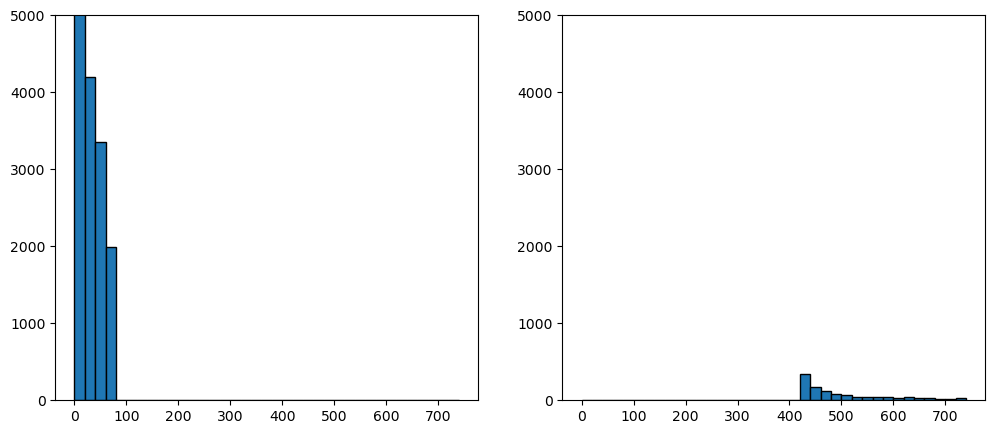

In [82]:
bin_edges = range(0, 721 + 21, 20) 

plt.figure(figsize=(12, 5))

plt.subplot(121 )
plt.hist(c1[1], bins=bin_edges, edgecolor='k')
plt.ylim(0, 5000)

plt.subplot(122 )
plt.hist(c10[1], bins=bin_edges, edgecolor='k')
plt.ylim(0, 5000)

In [ ]:
ens_with_counts.to_parquet("/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/")

In [10]:
# ens_s = ens._source.compute().loc[ix_src_count_sorted]

(array([   0.,    0., 1591., 2876., 2759., 2630., 2605., 2945., 3110.,
        3047., 2377., 2314., 1469., 1000.,  785.,  721.,  746.]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
        220., 240., 260., 280., 300., 320., 340.]),
 <BarContainer object of 17 artists>)

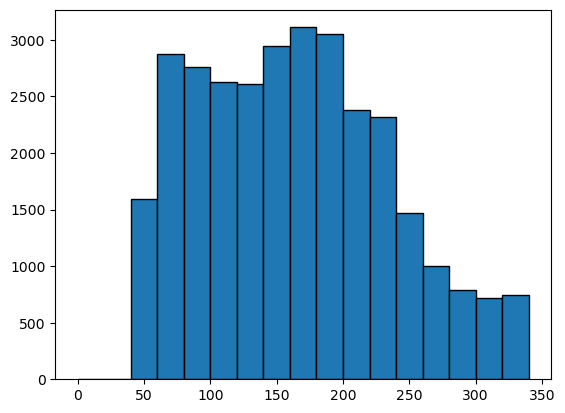

In [11]:
data = ens.compute('object')['nobs_total'].values.astype(int)

bin_edges = range(0, 321 + 21, 20) 
plt.hist(data, bins=bin_edges, edgecolor='k')

In [12]:
#ens._source = ens._source.loc[argsort_count]
#ens._source = ens._source.repartition(npartitions=11)

In [58]:
# Step 4: Use the sorted index to rearrange the Dask DataFrame
sorted_ens_source = ens._source.loc[sorted_count_df['_hipscat_index']].set_index('count')

KeyError: "Data has no column 'count': use any column of ['SDSS_NAME_dr16q_constant', 'PLATE_dr16q_constant', 'MJD_dr16q_constant', 'FIBERID_dr16q_constant', 'RA_dr16q_constant', 'DEC_dr16q_constant', 'OBJID_dr16q_constant', 'IF_BOSS_SDSS_dr16q_constant', 'Z_DR16Q_dr16q_constant', 'SOURCE_Z_DR16Q_dr16q_constant', 'Z_FIT_dr16q_constant', 'Z_SYS_dr16q_constant', 'Z_SYS_ERR_dr16q_constant', 'EBV_dr16q_constant', 'SN_MEDIAN_ALL_dr16q_constant', 'FEII_UV_EW_dr16q_constant', 'FEII_UV_EW_ERR_dr16q_constant', 'FEII_OPT_EW_dr16q_constant', 'FEII_OPT_EW_ERR_dr16q_constant', 'LOGL1350_dr16q_constant', 'LOGL1350_ERR_dr16q_constant', 'LOGL1700_dr16q_constant', 'LOGL1700_ERR_dr16q_constant', 'LOGL2500_dr16q_constant', 'LOGL2500_ERR_dr16q_constant', 'LOGL3000_dr16q_constant', 'LOGL3000_ERR_dr16q_constant', 'LOGL5100_dr16q_constant', 'LOGL5100_ERR_dr16q_constant', 'LOGLBOL_dr16q_constant', 'LOGLBOL_ERR_dr16q_constant', 'LOGMBH_HB_dr16q_constant', 'LOGMBH_HB_ERR_dr16q_constant', 'LOGMBH_MGII_dr16q_constant', 'LOGMBH_MGII_ERR_dr16q_constant', 'LOGMBH_CIV_dr16q_constant', 'LOGMBH_CIV_ERR_dr16q_constant', 'LOGMBH_dr16q_constant', 'LOGMBH_ERR_dr16q_constant', 'LOGLEDD_RATIO_dr16q_constant', 'LOGLEDD_RATIO_ERR_dr16q_constant', 'Norder_dr16q_constant', 'Dir_dr16q_constant', 'Npix_dr16q_constant', 'ps1_objid_ztf_dr14', 'ra_ztf_dr14', 'dec_ztf_dr14', 'ps1_gMeanPSFMag_ztf_dr14', 'ps1_rMeanPSFMag_ztf_dr14', 'ps1_iMeanPSFMag_ztf_dr14', 'nobs_g_ztf_dr14', 'nobs_r_ztf_dr14', 'nobs_i_ztf_dr14', 'mean_mag_g_ztf_dr14', 'mean_mag_r_ztf_dr14', 'mean_mag_i_ztf_dr14', 'Norder_ztf_dr14', 'Dir_ztf_dr14', 'Npix_ztf_dr14', '_DIST', 'index_ztf_source', 'ps1_objid_ztf_source', 'ra_ztf_source', 'dec_ztf_source', 'ps1_gMeanPSFMag_ztf_source', 'ps1_rMeanPSFMag_ztf_source', 'ps1_iMeanPSFMag_ztf_source', 'nobs_g_ztf_source', 'nobs_r_ztf_source', 'nobs_i_ztf_source', 'mean_mag_g_ztf_source', 'mean_mag_r_ztf_source', 'mean_mag_i_ztf_source', 'catflags_ztf_source', 'fieldID_ztf_source', 'mag_ztf_source', 'magerr_ztf_source', 'mjd_ztf_source', 'rcID_ztf_source', 'band_ztf_source', 'Norder_ztf_source', 'Dir_ztf_source', 'Npix_ztf_source', 'Norder', 'Dir', 'provenance']"

In [55]:
sorted_ens_source.divisions

(1466663657151660032,
 6301401302328934400,
 7309331294750507008,
 7393075548857040896,
 7449363382987128832,
 7491908577381056512,
 7673265556643905536,
 7714531938068856832,
 7767871274826596352,
 7813643606341713920,
 7856717655858741248,
 7888340770627780608)

In [56]:
sorted_ens_source.iloc[0]

NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

In [51]:
import dask.dataframe as dd

# Step 4: Create a custom partitioning scheme based on counts
# This function returns the partition number based on the count
def custom_partition_count(count):
    # You can customize this logic based on your requirements
    if count < 10:
        return 0
    elif count < 20:
        return 1
    else:
        return 2

# Apply the custom partitioning function to create a new column 'partition'
sorted_count_df['partition'] = sorted_count_df['count'].map(custom_partition_count)

# Step 5: Shuffle the Dask DataFrame based on the custom partitioning
shuffled_ens_source = dd.shuffle(ens._source, on='_hipscat_index', custom_partition=sorted_count_df[['partition']])


TypeError: 'module' object is not callable

In [44]:
 ens._source.divisions

(1466663657151660032,
 6301401302328934400,
 7309331294750507008,
 7393075548857040896,
 7449363382987128832,
 7491908577381056512,
 7673265556643905536,
 7714531938068856832,
 7767871274826596352,
 7813643606341713920,
 7856717655858741248,
 7888340770627780608)

In [45]:
sorted_ens_source.divisions

(None, None, None, None, None, None, None, None, None, None, None, None)

In [25]:
len(sorted_ens_source)

6775083

In [31]:
ens._source.get_partition(0).compute()

,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source,Norder,Dir,provenance
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
1472004965823152128,104317.19+312644.5,11384,58522,880,160.821638,31.445698,11384-58522-0880,BOSS,1.382894,PIPE,...,0.205420,58904.29603,40,g,6,0,5229,6,0,survey_1
1472045188816830464,104419.56+312806.2,6448,56365,158,161.081524,31.468406,6448-56365-0158,BOSS,1.947000,VI,...,0.209123,59228.46231,40,g,6,0,5229,6,0,survey_1
1468203608813076480,104140.43+273934.6,6453,56365,636,160.418498,27.659614,6453-56365-0636,BOSS,2.278000,VI,...,0.292328,58894.32398,36,g,6,0,5216,6,0,survey_1
1471455401554739200,103308.83+303957.3,6451,56358,296,158.286817,30.665931,6451-56358-0296,BOSS,0.768000,VI,...,0.239817,59165.52485,4,g,6,0,5227,6,0,survey_1
1470663236058611712,103600.01+293701.6,11353,58467,745,159.000054,29.617137,11353-58467-0745,BOSS,1.545970,PIPE,...,0.204554,58540.41900,28,g,6,0,5224,6,0,survey_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475647317552922624,104250.56+324230.9,2019,53430,449,160.710668,32.708590,2019-53430-0449,SDSS,0.960112,DR6Q_HW,...,0.037156,59725.27041,29,g,7,20000,20970,7,20000,survey_1
1475647317552922624,104250.56+324230.9,2019,53430,449,160.710668,32.708590,2019-53430-0449,SDSS,0.960112,DR6Q_HW,...,0.035717,59731.20627,29,g,7,20000,20970,7,20000,survey_1
1475647317552922624,104250.56+324230.9,2019,53430,449,160.710668,32.708590,2019-53430-0449,SDSS,0.960112,DR6Q_HW,...,0.036278,59723.23790,29,g,7,20000,20970,7,20000,survey_1


In [46]:
sorted_ens_source.get_partition(0).compute()

,_hipscat_index,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,...,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source,Norder,Dir,provenance
0,1472045188816830464,104419.56+312806.2,6448,56365,158,161.081524,31.468406,6448-56365-0158,BOSS,1.947000,...,0.209123,59228.46231,40,g,6,0,5229,6,0,survey_1
1,1471455401554739200,103308.83+303957.3,6451,56358,296,158.286817,30.665931,6451-56358-0296,BOSS,0.768000,...,0.239817,59165.52485,4,g,6,0,5227,6,0,survey_1
2,1467779055209152512,110009.14+312233.2,11386,58514,792,165.038112,31.375901,11386-58514-0792,BOSS,1.003293,...,0.206176,58601.24874,45,g,6,0,5214,6,0,survey_1
3,1466683239627227136,105406.50+300727.6,6449,56356,950,163.527106,30.124338,6449-56356-0950,BOSS,1.655000,...,0.217214,58580.21105,39,g,6,0,5210,6,0,survey_1
4,1476240320936017920,105002.49+332800.6,10268,58487,504,162.510393,33.466858,10268-58487-0504,BOSS,3.165908,...,0.225472,58985.16489,11,g,6,0,5244,6,0,survey_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675179,1469877569904967680,104416.60+293540.7,10471,58132,197,161.069201,29.594648,10471-58132-0197,BOSS,0.678839,...,0.070754,58885.31597,3,g,6,0,5222,6,0,survey_1
675180,1469877569904967680,104416.60+293540.7,10471,58132,197,161.069201,29.594648,10471-58132-0197,BOSS,0.678839,...,0.071849,58884.30348,3,g,6,0,5222,6,0,survey_1
675181,1469877569904967680,104416.60+293540.7,10471,58132,197,161.069201,29.594648,10471-58132-0197,BOSS,0.678839,...,0.057892,58884.30257,3,g,6,0,5222,6,0,survey_1
675182,1469877569904967680,104416.60+293540.7,10471,58132,197,161.069201,29.594648,10471-58132-0197,BOSS,0.678839,...,0.075599,58885.29583,49,g,6,0,5222,6,0,survey_1


In [47]:
ens_s0 = sorted_ens_source.get_partition(0).compute()
ens_s10 = sorted_ens_source.get_partition(10).compute()

(0.0, 500.0)

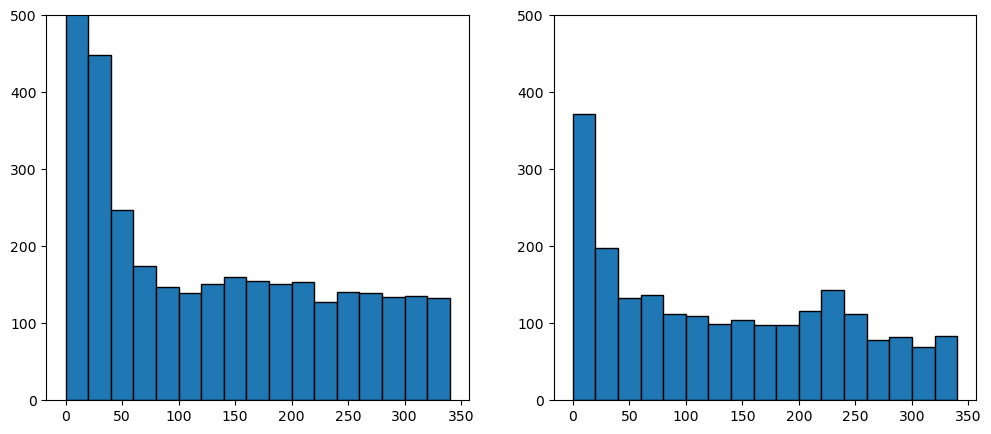

In [49]:
ens_s0_ix_count = np.unique(ens_s0['_hipscat_index'], return_counts=True)
ens_s10_ix_count = np.unique(ens_s10['_hipscat_index'], return_counts=True)
bin_edges = range(0, 321 + 21, 20) 

plt.figure(figsize=(12, 5))

plt.subplot(121 )
plt.hist(ens_s0_ix_count[1], bins=bin_edges, edgecolor='k')
plt.ylim(0, 500)

plt.subplot(122 )
plt.hist(ens_s10_ix_count[1], bins=bin_edges, edgecolor='k')
plt.ylim(0, 500)

In [36]:
ens_s10

,SDSS_NAME_dr16q_constant,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source,Norder,Dir,provenance
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
7858739334596263936,124530.92+141044.7,5410,56016,732,191.378874,14.179089,5410-56016-0732,BOSS,2.059,VI,...,0.194416,58963.28971,27,g,6,20000,27919,6,20000,survey_1
7862444922933084160,125924.93+151023.7,5416,56002,875,194.853886,15.173264,5416-56002-0875,BOSS,2.881,VI,...,0.199359,58963.29068,17,g,6,20000,27933,6,20000,survey_1
7865295180683804672,123905.65+144425.5,5405,56010,832,189.773580,14.740425,5405-56010-0832,BOSS,1.680,VI,...,0.296581,59307.29754,48,g,6,20000,27943,6,20000,survey_1
7867381216897400832,122935.62+153727.7,5404,56013,434,187.398455,15.624369,5404-56013-0434,BOSS,0.802,VI,...,0.149177,58492.53913,34,g,6,20000,27950,6,20000,survey_1
7886554917484101632,130209.86+204808.0,5860,56046,688,195.541106,20.802235,5860-56046-0688,BOSS,2.644,VI,...,0.183387,58540.44084,19,g,6,20000,28018,6,20000,survey_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7887881993017360384,131336.84+223609.9,2651,54507,466,198.403536,22.602752,2651-54507-0466,SDSS,1.313,DR7QV_SCH,...,0.048827,58236.23721,2,g,7,110000,112093,7,110000,survey_1
7887881993017360384,131336.84+223609.9,2651,54507,466,198.403536,22.602752,2651-54507-0466,SDSS,1.313,DR7QV_SCH,...,0.042119,58236.31839,2,g,7,110000,112093,7,110000,survey_1
7887881993017360384,131336.84+223609.9,2651,54507,466,198.403536,22.602752,2651-54507-0466,SDSS,1.313,DR7QV_SCH,...,0.046912,58236.32960,2,g,7,110000,112093,7,110000,survey_1


In [ ]:
ens._source = ens._source.loc[ix_src_count_sorted]
ens._source.reset_index().set_index("_hipscat_index").to_parquet("/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/")


## checking the result 

In [24]:
import glob

directory_path = '/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/'
file_pattern = '*.parquet'

matching_files = glob.glob(f'{directory_path}{file_pattern}')

for file_path in matching_files:
    print(file_path)

/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.1.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.0.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.19.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.13.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.21.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.5.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.18.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.20.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.3.parquet
/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_s

In [31]:
test_0 = pd.read_parquet("/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.0.parquet")
test_12 = pd.read_parquet("/astro/store/epyc3/data3/hipscat/catalogs/ztf_dr14_x_agns_source_repar_big_shuffled_test/part.12.parquet")

In [32]:
test_0_counts = np.unique(test_0.index, return_counts=True)
test_12_counts = np.unique(test_12.index, return_counts=True)

In [33]:
test_0_counts[1]

array([233, 244,  45, ..., 355, 341, 330])

(0.0, 500.0)

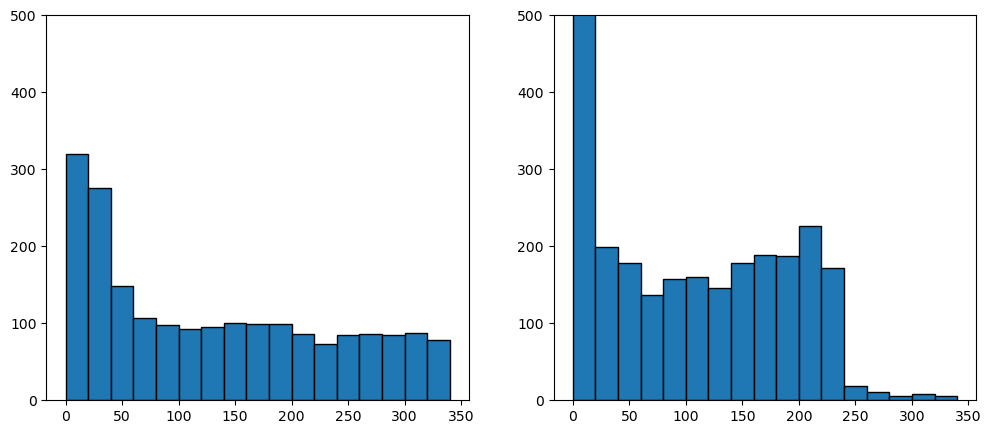

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(121 )
plt.hist(test_0_counts[1], bins=bin_edges, edgecolor='k')
plt.ylim(0, 500)

plt.subplot(122 )
plt.hist(test_12_counts[1], bins=bin_edges, edgecolor='k')
plt.ylim(0, 500)